In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
# загружаем описание облигаций
bond_count = 5
bond_info = {}

for bond_i in range(bond_count): 
    coupons_i = pd.read_excel('офз_график_выплат.xlsx', sheet_name=bond_i)[['Date', 'Coupon']].astype({'Date':'M8[D]'})   

    info = pd.read_excel('офз_описание.xlsx', bond_i, index_col=0)
    num_coupons = info.loc['Периодичность выплаты купона в год'].values[0]
    face = info.loc['Номинальная стоимость'].values[0]
    expDate = np.datetime64(info.loc['Дата погашения'].values[0])

    coupons_rate = coupons_i['Coupon'].values / num_coupons / 100
    coupons_date = coupons_i['Date'].values 
    # coupons_rate = coupons_rate[coupons_date > tradeDate1]  
    # coupons_date = coupons_date[coupons_date > tradeDate1].reshape(-1,1)
    
    bond_info[bond_i] = {
        'coupons_date': coupons_date,
        'coupons_rate': coupons_rate,
        'expDate': expDate,
        'faceValue': face,
        'num_coupons': num_coupons
    }

In [4]:
# загружаем историю кривых доходностей
ir = pd.read_excel('офз.xlsx', index_col=0, header=1) / 100 / 360

In [5]:
dates = np.array(['-'.join(x.split('.')[::-1]) for x in ir.index]).astype('M8[D]')
ir.index = dates
ir.sort_index(inplace=True)
dates = dates[::-1][1:]

In [6]:
ir_diff = ir.diff().dropna()# берем разности

In [7]:
# загружаем историю котировок цен облигаций
market_price = {}
for bond_i in range(bond_count):
    market_price[bond_i] =  pd.read_excel('офз_данные.xlsx', bond_i, usecols=[2,7]).set_index('<DATE>')

In [8]:
pca = PCA(n_components=3)
components = pca.fit_transform(ir_diff)

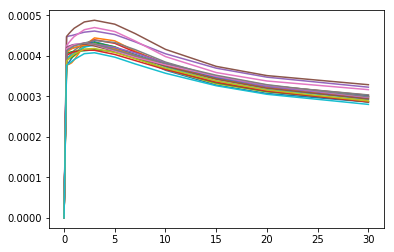

In [9]:
for i in range(20):
    plt.plot(np.concatenate((np.zeros(1), ir.columns)), np.concatenate((np.zeros(1), ir.iloc[i].values)))

explain_var for 3 comp 0.954 %


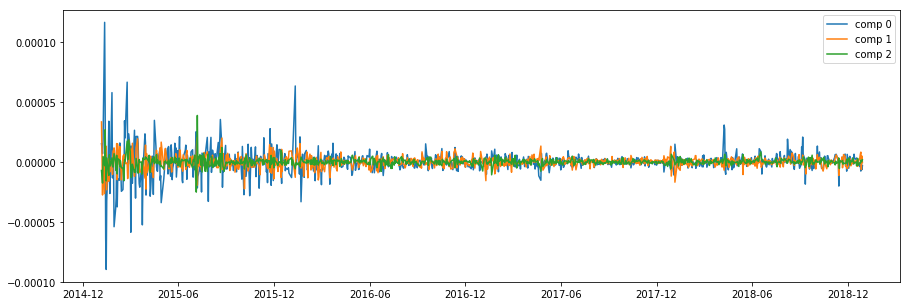

In [10]:
print(f"explain_var for 3 comp {pca.explained_variance_ratio_[:3].sum():.3f} %")
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(dates, components[:,i], label=f"comp {i}")
plt.legend();

In [11]:
def ClosestTradeDate(day, dates = dates, back=1):
    return dates[dates <= day][-back]

last traid date before forecase 2018-11-30
forecast date 2018-12-03


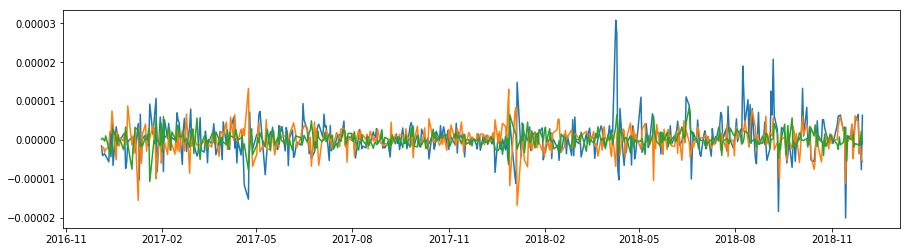

In [12]:
forecastDate = np.datetime64('2018-12-03')
tradeDate1 = ClosestTradeDate(forecastDate-1)
tradeDate10 = ClosestTradeDate(forecastDate-10)
startDate = np.datetime64('2016-12-03')

print('last traid date before forecase', tradeDate1)
print('forecast date', forecastDate)

#logr = np.log(first_comp[dates < forDate] - min(first_comp[dates < forDate]) + 0.002)
components_for = components[(dates <= tradeDate1) & (dates >= startDate)]

r0_diff = components_for[-1] # разница ставок в момент tradeDate1 для каждой из компоненты
r0 = ir.loc[tradeDate1] # реальная кривая в момент времени tradeDate1

plt.figure(figsize=(15,4))
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,0])
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,1])
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,2]);

__Vasicek Model:__ $dr_t = \alpha(b-r_t)dt + \sigma dW_t$   
Точное решение: $r_t \sim N\left(r_0 e^{-\alpha t} + b (1-e^{-\alpha t}),\,\tfrac{\sigma^2}{2\alpha}\left(1-e^{-2\alpha t}\right)\right)
$

In [13]:
# метод максимума правдоподобия
def minimizeNLogLikelihood(r, dates):
    dt = 1 
    rt = r    
    N = r.shape[0]
    params0 = np.array([0.0000001,0.0000001,0.0000001])
    
    def VasicekLogLikelihood(params):
        alpha, b, sigma = params[0], params[1], params[2] 
        return -(N-1)*np.log(alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))) \
            - alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))*np.sum(-(rt[:-1] - rt[1:]*np.exp(-alpha*dt)-b*(1-np.exp(-alpha*dt)))**2) 
    
    params_opt = minimize(VasicekLogLikelihood, params0, method='Powell')
    return params_opt.x

In [14]:
# генерируем приращения после pca для момента forDate 
def VasicekPath(params,r0, N):
    dt = 1    
    alpha, b, sigma = params[0], params[1], params[2]
    r = [] # варианты аля-ставки на один из аля-TtM  
    for j in range(N):
        r1 = r0 + alpha*(b-r0)*dt + sigma*np.sqrt(dt)*np.random.randn()
        r.append(r1)
    return r

In [31]:
def CalibrateYieldCurves(bond_count, n_components=3, N=100, n_params=3):
    params = np.zeros((n_components,n_params))
    for i in range(n_components):
        params[i] = minimizeNLogLikelihood(components[:,i], dates)
        
    yeild_curves = [[[]]*N]*bond_count
    xnew = np.arange(1, 30*360, 1)
    
    for bond_i in range(bond_count): 
        
        # генерируем сценарии для главных компонент (матрица размером N*n_components)
        pca_simulations = [VasicekPath(params[j], r0_diff[j], N) for j in range(n_components)] 
        
        # преобразуем сценарии компонент в сценарии разностей реальных ставок 
        inverse_r = pca.inverse_transform(np.array(pca_simulations).T)
        
        # переводим сценарии разностей в сценарии кривых доходностей 
        inverse_r = r0.values + inverse_r
        
        # интерполируем
        x = [0]+list(r0.index*360)        
        for j, ofz in enumerate(inverse_r):
            y = [0]+list(ofz)
            f = interp1d(x, y)
            ynew = f(xnew)
            yeild_curves[bond_i][j] = ynew
            
    return np.array(yeild_curves)

In [32]:
yeild_curves = CalibrateYieldCurves(bond_count)

In [33]:
len(yeild_curves[bond_i])

100

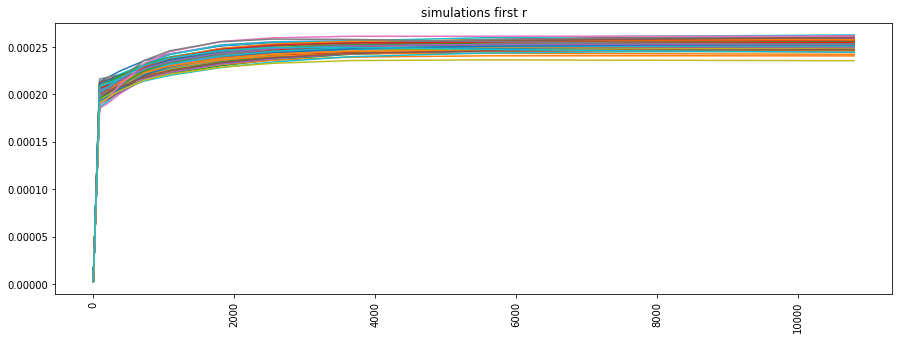

In [34]:
#пример симуляции N ставок для каждой из компоненты

bond_i = 1 # далее будем смотреть на конкретную облигацию
bond_result = yeild_curves[bond_i]

dates_index = pd.date_range(forecastDate, bond_info[bond_i]['expDate'])[:-1]

plt.figure(figsize =(15,5))
for i in bond_result:
    plt.plot(i)
plt.title('simulations first r')
plt.xticks(rotation=90);

In [ ]:
# #переводим аля-ставки в разности реальных ставок 
# inverse_r = pca.inverse_transform(bond_result['simulations'])

# #переводим разности в кривую YTM. 
# inverse_r = r0.values + inverse_r

In [ ]:
# #используем линейную интерполяцию (дневную)
# from scipy.interpolate import interp1d

# x = [0]+list(r0.index*360)
# xnew = np.arange(1, 30*360, 1)

# inverse_r_interpolate = np.zeros((inverse_r.shape[0], len(xnew)))

# for i, ofz in enumerate(inverse_r):
#     y = [0]+list(ofz)
    
#     f = interp1d(x, y)
#     ynew = f(xnew)
    
#     inverse_r_interpolate[i] = ynew

In [ ]:
# # наши смоделированные N кривыx на дату forDate
# for i in range(10):
#     plt.plot(xnew[10:], inverse_r_interpolate[i, 10:]);

In [ ]:
# for i in range(inverse_r_interpolate.shape[0]):
#     plt.plot(inverse_r_interpolate[i])

In [35]:
def PriceCouponBond(yeild_curves, tradeDate, bond_info, N):
    coupons_rate = bond_info['coupons_rate'][bond_info['coupons_date'] > tradeDate]
    coupons_date = bond_info['coupons_date'][bond_info['coupons_date'] > tradeDate].reshape(-1,1)
    num_coupons = bond_info['num_coupons']
    faceValue = bond_info['faceValue']
    
    TimeToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate)/np.timedelta64(1,'D')), 1, coupons_date)
    B = np.zeros((N, TimeToMaturity[-1]))
    discount_factor = ((1+yeild_curves[:, :TimeToMaturity[-1]])**np.arange(TimeToMaturity[-1]))[:, ::-1]

    for i in range(N):    
        #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
        for j,_ in enumerate(TimeToMaturity):        
            V = faceValue*coupons_rate[j]/num_coupons if j != len(TimeToMaturity)-1 else faceValue*\
                (1+coupons_rate[j]/num_coupons) 
            B[i, :TimeToMaturity[j]] += (V / discount_factor[i, :TimeToMaturity[j]])
    return B

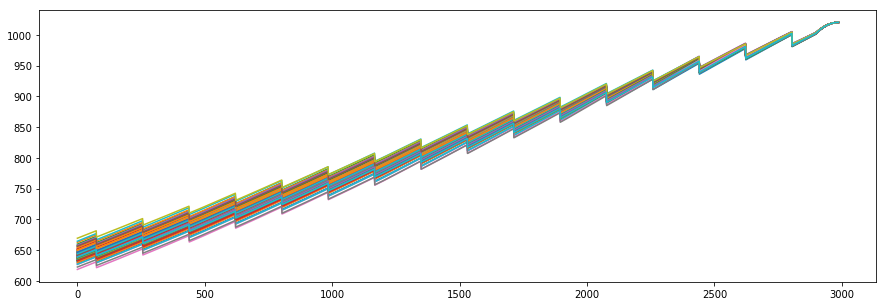

In [36]:
price_bond = PriceCouponBond(bond_result, tradeDate1, bond_info[bond_i], len(bond_result))
plt.figure(figsize=(15,5))
for i in range(price_bond.shape[0]):
    plt.plot(price_bond[i])

### Прогноз и VaR на 1 день

In [37]:
lag1 = int((forecastDate-tradeDate1)/np.timedelta64(1,'D'))
yeilds1 = (price_bond[:, lag1] - price_bond[:, 0])/price_bond[:,0]
losses1 = (market_price[bond_i].loc[forecastDate]['<CLOSE>'] - market_price[bond_i].loc[tradeDate1]['<CLOSE>']*(1+yeilds1)) /\
            market_price[bond_i].loc[forecastDate]['<CLOSE>']

In [38]:
market_loss1 = (market_price[bond_i].loc[forecastDate]['<CLOSE>'] - market_price[bond_i].loc[tradeDate1]['<CLOSE>'])/\
            market_price[bond_i].loc[tradeDate1]['<CLOSE>']
var = np.percentile(losses1, 99)

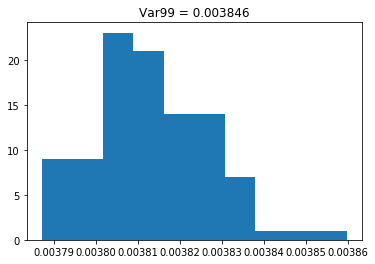

In [39]:
plt.hist(losses1)
plt.title('Var99 = %.6f' % var);

### Прогноз и VaR на 10 дней

In [ ]:
price_bond10 = PriceCouponBond(inverse_r_interpolate, tradeDate10, bond_result)
plt.figure(figsize=(15,5))
for i in range(price_bond10.shape[0]):
    plt.plot(price_bond10[i])

In [ ]:
lag10 = int((forecastDate-tradeDate10)/np.timedelta64(1,'D'))
yeilds10 = (price_bond10[:, lag10] - price_bond10[:, 0])/price_bond10[:,0]

In [ ]:
forecast10 = market_price[bond_i].loc[tradeDate10]['<CLOSE>']*(1+yeilds10)

In [ ]:
np.percentile(market_price[bond_i].loc[forecastDate]['<CLOSE>'] - forecast10, 99)

## Backtesting 

In [188]:
year_start = np.datetime64('2018-01-01')
year_end = np.datetime64('2018-01-15')

In [195]:
bond_count = 1
N = 100
test_period = dates[(dates >= year_start) & (dates <= year_end)]
var = np.zeros((test_period.shape[0], bond_count, 2))
price = np.zeros((bond_count, test_period.shape[0], 2))
for v, forecastDate in enumerate(test_period):
    tradeDate1 = ClosestTradeDate(forecastDate-1)
    tradeDate10 = ClosestTradeDate(forecastDate-10)
    startDate = ClosestTradeDate(forecastDate-730) # начало окна, ширина 2 года  

#     print('window', startDate, tradeDate1)
#     print('forecast date', forecastDate)

    components_for = components[(dates <= tradeDate1) & (dates >= startDate)]
    r0_diff = components_for[-1] # разница ставок в момент tradeDate1 для каждой из компоненты
    r0 = ir.loc[tradeDate1] # реальная кривая в момент времени tradeDate1
    
    yeild_curves = CalibrateYieldCurves(bond_count)
        
    for bond_i in range(bond_count):
        price_bond = PriceCouponBond(yeild_curves[bond_i], tradeDate1, bond_info[bond_i], 100)
#         lag1 = int((forecastDate-tradeDate1)/np.timedelta64(1,'D'))
        
        market_today = market_price[bond_i].loc[tradeDate1]['<CLOSE>']
        market_tomorrow = market_price[bond_i].loc[forecastDate]['<CLOSE>']
        print('market_tomorrow', market_tomorrow)
        
        yeilds1 = (price_bond[:, 1] - price_bond[:, 0])/price_bond[:,0]
        losses1 = (market_today-market_today*(1+yeilds1)) / market_today
        print('losses1', losses1)
        market_loss1 = (market_today-market_tomorrow)/ market_today
        
        price[bond_i,v, 0] = market_today*(1+yeilds1.mean())
        price[bond_i,v, 1] = market_tomorrow
        
        var[v, bond_i, 0] = np.percentile(losses1, 99)
        var[v, bond_i, 1] = market_loss1

market_tomorrow 102.6
losses1 [-0.0002143  -0.00021507 -0.00021968 -0.00021197 -0.0002132  -0.0002156
 -0.00020675 -0.00021413 -0.0001994  -0.00020978 -0.00020434 -0.00021619
 -0.0002165  -0.00021323 -0.00020609 -0.00020909 -0.00021065 -0.00021408
 -0.00021464 -0.00021542 -0.00020713 -0.00021228 -0.00020792 -0.00020828
 -0.00021044 -0.00021962 -0.00021566 -0.00021333 -0.00022371 -0.00021213
 -0.00020885 -0.00020648 -0.00021926 -0.00020606 -0.00022238 -0.00021172
 -0.0002131  -0.00020336 -0.00022142 -0.00022294 -0.0002167  -0.00022135
 -0.00021055 -0.00021048 -0.00021061 -0.0002188  -0.00021369 -0.00021278
 -0.00020015 -0.00021649 -0.0002082  -0.00021186 -0.00020568 -0.00021186
 -0.0002122  -0.00021204 -0.00021719 -0.00021157 -0.00021911 -0.00020919
 -0.00021904 -0.00021055 -0.00020707 -0.00020998 -0.00020492 -0.00020619
 -0.00021132 -0.0002143  -0.00021633 -0.00021678 -0.0002028  -0.00020881
 -0.0002153  -0.00021869 -0.00020493 -0.00021532 -0.00020608 -0.00020842
 -0.00020464 -0.000217

 -0.00019123 -0.00019712 -0.00019457 -0.00020304]
market_tomorrow 102.90100000000001
losses1 [-0.00020736 -0.00020175 -0.00020413 -0.00020749 -0.00022017 -0.0002088
 -0.0002042  -0.00020374 -0.00020347 -0.00019895 -0.00020712 -0.00022631
 -0.00020305 -0.00020628 -0.00021376 -0.00020104 -0.00020967 -0.00021126
 -0.00019966 -0.00020569 -0.00020797 -0.00021207 -0.00020221 -0.00019781
 -0.00021667 -0.00021432 -0.00020817 -0.00021585 -0.00021477 -0.00021198
 -0.00020664 -0.00020589 -0.00021415 -0.00020338 -0.00020317 -0.00020549
 -0.00020183 -0.00020264 -0.00020446 -0.00020875 -0.00021025 -0.00020721
 -0.00020857 -0.00020051 -0.00021419 -0.00020389 -0.00020679 -0.00021089
 -0.00020647 -0.00021233 -0.00021233 -0.00018964 -0.00020255 -0.00020125
 -0.0002186  -0.00020304 -0.0002051  -0.00020729 -0.00021617 -0.0001998
 -0.00020214 -0.00020985 -0.0002171  -0.00020246 -0.00020646 -0.00021558
 -0.00020849 -0.00020766 -0.00019458 -0.00020292 -0.0002031  -0.00020984
 -0.00020796 -0.00018886 -0.00019

In [190]:
ClosestTradeDate(test_period[0]-1)

numpy.datetime64('2017-12-29')

In [191]:
market_price[0].loc[ClosestTradeDate(test_period[0]-1)]['<CLOSE>']

104.0

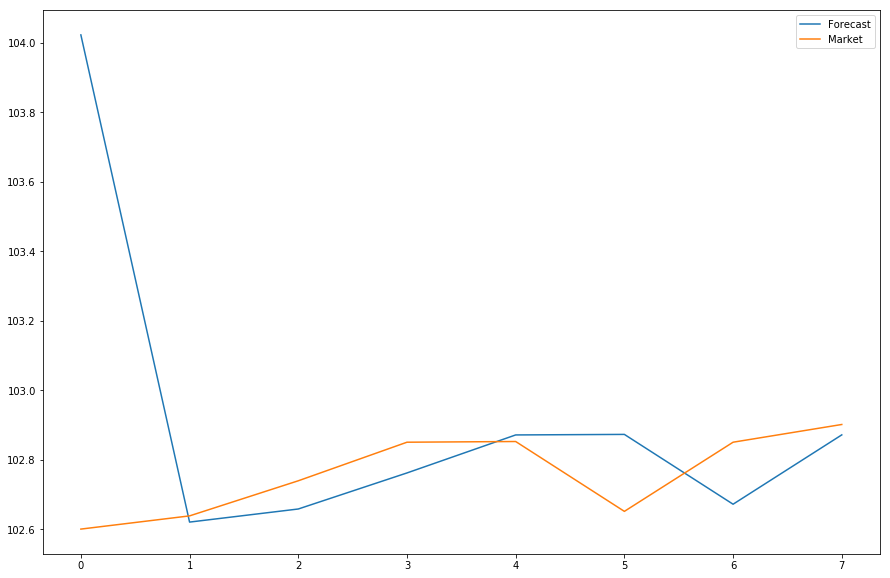

In [192]:
plt.figure(figsize=(15, 10))
plt.plot(price[0, :, 0], label='Forecast')
plt.plot(price[0, :, 1], label='Market')
plt.legend();

In [196]:
price[0, :, 0]

array([104.02207296, 102.62015842, 102.65788487, 102.76164826,
       102.87098071, 102.87237612, 102.67151215, 102.87122674])

In [198]:
# количество пробоев
var[:,:,0] < var[:,:,1], 

(array([[ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False]]),)

In [115]:
price[0, :, 0].reshape(1, -1).shape

(1, 251)

In [150]:
# def BondPortfolioPrice(prices, start_prices, V=10000000):
#     nums = np.zeros((prices.shape[0], prices.shape[1]))
#     portfolio = np.zeros((prices.shape[1], prices.shape[-1]))
#     nums[:, 0] = V/start_prices
#     portfolio[0, 0] = portfolio[0, 1]= V*prices.shape[0]
# #     print(prices.shape, nums.shape, portfolio.shape)
#     for i in range(1,prices.shape[1]):
#         nums[:, i] = V / prices[:, i, 0]
# #         if i == 3:
# #             print(nums[:, :i], prices[:, i, 0])
#         portfolio[i, 0] = np.sum(nums[:, i-1]*prices[:, i, 0])
#         portfolio[i, 1] = np.sum(nums[:, i-1]*prices[:, i, 1])
#     return portfolio

In [156]:
def BondPortfolioVAR(prices, V=10000000):
    nums = np.zeros((prices.shape[0], prices.shape[1]))
    var = np.zeros(prices.shape[1])
    nums = V/prices[:,:,0][1:]
    portfolio = np.zeros((prices.shape[1], prices.shape[-1]))
#     print(prices.shape, nums.shape, portfolio.shape)
    portfolio[:, 0] = np.sum(nums*prices[:, :, 0][1:])
    portfolio[:, 1] = np.sum(nums*prices[:, :, 1][:-1])
    var = (portfolio[:, 1] - portfolio[:, 0])/portfolio[:, 0]  
    return var, portfolio

In [158]:
VAr, port = BondPortfolioVAR(price[:2].reshape(2, -1, price.shape[-1]))

In [159]:
VAr

array([-0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01426001,
       -0.01426001, -0.01426001, -0.01426001, -0.01426001, -0.01

In [161]:
def rebalance(amount0, p_path):
    w = amount0 / sum(amount0)
    
    count = amount0 / p_path[:, 0]
    
    for i in range(1, p_path.shape[1]):
        p = p_path[:, i]
        port_value = sum(p * count)
        count = (port_value * w) / p
        
        
    return sum(count * p)

In [160]:
def estimate_VaR(amount0, p_pathes, N, alpha=0.9):
    p0_real = p_pathes[:, 0, 0]
    
    port_value_0 = sum(amount0)
    
    port_value_last = np.zeros(N)
    
    for i in range(N):
        p_path = np.array([x[i] for x in p_pathes])
        port_value_last[i] = rebalance(amount0, p_path)
        
    distr = (port_value_0 - port_value_last) / port_value_0

    return np.percentile(distr, alpha*100)

In [ ]:
# def PriceCouponBond(yeild_curves, tradeDate, forecastDate, bond_info):
#     coupons_rate = bond_info['coupons_rate'][bond_info['coupons_date'] > tradeDate]
#     coupons_date = bond_info['coupons_date'][bond_info['coupons_date'] > tradeDate]
#     num_coupons = bond_info['num_coupons']
#     faceValue = bond_info['faceValue']
#     lag = (forecastDate - tradeDate)
    
#     TimeToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate)/np.timedelta64(1,'D')), 1, coupons_date)
#     B = np.zeros((yeild_curves.shape[0],2))
#     for i in range(N):    
#         #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
#         for j,_ in enumerate(TimeToMaturity):        
#             V = faceValue*coupons_rate[j]/num_coupons if j != len(TimeToMaturity)-1 
#                 else faceValue*(1+coupon_rate[j]/num_coupons)  
#             discount_today = (1+yeild_curves[i][TimeToMaturity[j]]/num_coupons)**TimeToMaturity[j]
#             discount_tomorrow = (1+yeild_curves[i][TimeToMaturity[j]-1]/num_coupons)**(TimeToMaturity[j]-1)
#             B[i][0] += (V/discount_today)
#             B[i][1] += (V/discount_tomorrow)
#     return B